### **Assignment 3**
 -- Chirag Mandal & Budhaditya Mukhopadhyay



## **MNIST using Gradient Tape**

---




In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

In [0]:
fashion = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# first difference: data is not reshaped to 784 anymore, but 28x28x1
# note the 1 color channel!! this is important
data = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, y_train.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, y_test.astype(np.int32))).batch(10000)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.shuffle(buffer_size=10000).batch(batch_size=128, drop_remainder=True)

In [15]:
train_steps = 1000

# convolutional kernels/biases
W = tf.Variable(tf.random.uniform([5, 5, 1, 16], -0.1, 0.1))
b = tf.Variable(tf.zeros([16]))
W1 = tf.Variable(tf.random.uniform([5, 5, 16, 32], -0.1, 0.1))
b1 = tf.Variable(tf.zeros([32]))

# fully connected layer at the end
W_d = tf.Variable(tf.random.uniform([7*7*32, 10]))
b_d = tf.Variable(tf.zeros([10]))

varis = [W, b, W1, b1, W_d, b_d]

print(W1.shape)
# 2 conv layers, each followed by 2x2 max pool
# you should look up the parameters in the API!
def model(inp):
    conv1 = tf.nn.relu(tf.nn.conv2d(inp, W, 1, padding="SAME") + b)
    conv1 = tf.nn.max_pool2d(conv1, 2, 2, padding="SAME")
    conv2 = tf.nn.relu(tf.nn.conv2d(conv1, W1, 1, padding="SAME") + b1)
    conv2 = tf.nn.max_pool2d(conv2, 2, 2, padding="SAME")
    conv2 = tf.reshape(conv2, [-1, 7*7*32])  # "flatten"

    logits = tf.matmul(conv2, W_d) + b_d

    return logits


# Adam makes things much smoother
opt = tf.optimizers.Adam()
# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

(5, 5, 16, 32)


In [10]:
# this basically hasn't changed
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        xent = loss_fn(lbl_batch, logits)

    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))

Loss: 3.351839065551758 Accuracy: 0.09375
Loss: 0.7552639245986938 Accuracy: 0.7578125
Loss: 0.511161208152771 Accuracy: 0.796875
Loss: 0.44462114572525024 Accuracy: 0.828125
Loss: 0.39148300886154175 Accuracy: 0.8671875
Loss: 0.30230358242988586 Accuracy: 0.8671875
Loss: 0.49895474314689636 Accuracy: 0.828125
Loss: 0.34955012798309326 Accuracy: 0.875
Loss: 0.5019477605819702 Accuracy: 0.8515625
Loss: 0.3121638298034668 Accuracy: 0.890625
Loss: 0.28033214807510376 Accuracy: 0.890625


Using Keras Layers

In [17]:
train_steps = 10000
model = models.Sequential()
model.add(layers.Conv2D(28, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(28, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))
model.summary()

# Adam makes things much smoother
opt = tf.optimizers.Adam(learning_rate=0.001)
# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy()

# this basically hasn't changed
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        xent = loss_fn(lbl_batch, logits)

    grads = tape.gradient(xent, model.trainable_weights)
      
    opt.apply_gradients(zip(grads, model.trainable_weights))
    
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 28)        728       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 28)        19628     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 28)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1372)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                13730     
Total params: 34,086
Trainable params: 34,086
Non-trainable params: 0
__________________________________________________

In [18]:
# here's some evaluation magic ;) bonus: figure out how this works...
big_test_batch = next(iter(test_data))
test_preds = tf.argmax(model(big_test_batch[0]), axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, big_test_batch[1]),
                             tf.float32))
print(acc)  

tf.Tensor(0.9123, shape=(), dtype=float32)


## **CIFAR 10 using Gradient Tape**

In [0]:
%tensorflow_version 2.x  # Colab...

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab...`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

truck


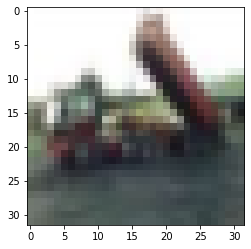

In [0]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print(class_names[train_labels[2,0]])
plt.imshow(train_images[2])

# first difference: data is not reshaped to 784 anymore, but 28x28x1
# note the 1 color channel!! this is important
data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(10000)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
val_dataset = val_dataset.shuffle(buffer_size=10000).batch(batch_size=128, drop_remainder=True)

In [0]:
train_steps = 4000

# convolutional kernels/biases
W = tf.Variable(tf.random.uniform([5, 5, 3, 16], -0.1, 0.1))
b = tf.Variable(tf.zeros([16]))
W1 = tf.Variable(tf.random.uniform([5, 5, 16, 32], -0.1, 0.1))
b1 = tf.Variable(tf.zeros([32]))
print(b)
# fully connected layer at the end
W_d = tf.Variable(tf.random.uniform([8*8*32, 10]))
b_d = tf.Variable(tf.zeros([10]))

varis = [W, b, W1, b1, W_d, b_d]


# 2 conv layers, each followed by 2x2 max pool
# you should look up the parameters in the API!
def model(inp):
    conv1 = tf.nn.relu(tf.nn.conv2d(inp, W, 1, padding="SAME") + b)
    conv1 = tf.nn.max_pool2d(conv1, 2, 2, padding="SAME")
    conv2 = tf.nn.relu(tf.nn.conv2d(conv1, W1, 1, padding="SAME") + b1)
    conv2 = tf.nn.max_pool2d(conv2, 2, 2, padding="SAME")
    conv2 = tf.reshape(conv2, [-1, 8*8*32])  # "flatten"

    logits = tf.matmul(conv2, W_d) + b_d

    return logits


# Adam makes things much smoother
opt = tf.optimizers.Adam()
# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

<tf.Variable 'Variable:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>


In [0]:
train_steps = 10000
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
model.summary()
# Adam makes things much smoother
opt = tf.optimizers.Adam(learning_rate=0.001)
# from_logits = True!! #neverforget
loss_fn = tf.losses.SparseCategoricalCrossentropy()

In [0]:
# this basically hasn't changed
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        xent = loss_fn(lbl_batch, logits)

    grads = tape.gradient(xent, model.trainable_weights) #varis
      
    opt.apply_gradients(zip(grads, model.trainable_weights))
    
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                             tf.float32))
        print("Loss: {} Accuracy: {}".format(xent, acc))
    

In [0]:
 val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  # Run a validation loop at the end of each epoch.
for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    val_acc_metric(y_batch_val, val_logits)
val_acc = val_acc_metric.result()
val_acc_metric.reset_states()
print('Validation Accuracy : %s' % (float(val_acc),))

Validation Accuracy : 0.33794069290161133


In [0]:
# here's some evaluation magic ;) bonus: figure out how this works...
big_test_batch = next(iter(test_data))
test_preds = tf.argmax(model(big_test_batch[0]), axis=1,
                       output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, big_test_batch[1]),
                             tf.float32))
print(acc)

tf.Tensor(0.1, shape=(), dtype=float32)


## **Using Keras**
---


### **CIFAR DATASET**

In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

170500096/170498071 [==============================] - 6s 0us/step
truck


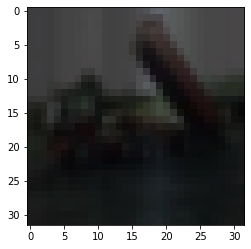

In [0]:
cifar = tf.keras.datasets.cifar10
#Load Data
(cx_train, cy_train), (cx_test, cy_test) = cifar.load_data()

#Normalize
cx_train = tf.keras.utils.normalize(cx_train, axis=1)
cx_test = tf.keras.utils.normalize(cx_test, axis=1)

#Initialize Class Labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print(class_names[cy_train[2,0]])
plt.imshow(cx_train[2])

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [0]:
opt = tf.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(cx_train, cy_train, epochs=200, 
                    validation_data=(cx_test, cy_test))

### **MNIST DATA SET**

In [0]:
import tensorflow as tf

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [0]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap=plt.cm.binary)

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(700, activation=tf.nn.relu))

model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(x_train,y_train,epochs=3)

Epoch 1/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2262 - accuracy: 0.9346
Epoch 2/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0885 - accuracy: 0.9732
Epoch 3/3
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0555 - accuracy: 0.9825


In [0]:
val_loss, val_accuracy = model.evaluate(x_test,y_test)
print(val_loss, val_loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.0849 - accuracy: 0.9735
0.08485309779644012 0.08485309779644012


In [0]:
model.save('num_loader.model')

INFO:tensorflow:Assets written to: num_loader.model/assets


In [0]:
new_model = tf.keras.models.load_model('num_loader.model')

In [0]:
predictions = new_model.predict(x_test)

In [0]:
print(predictions)

[[3.1089574e-08 4.3276347e-09 6.7435758e-07 ... 9.9999881e-01
  6.9544520e-10 8.1098321e-08]
 [4.8485695e-08 7.2050927e-05 9.9992764e-01 ... 3.9990420e-12
  2.7928719e-09 5.1928411e-13]
 [1.3544968e-07 9.9943095e-01 1.2287829e-04 ... 1.5797022e-04
  2.7267981e-04 5.1990952e-07]
 ...
 [2.3093407e-09 4.4466441e-07 5.5792057e-08 ... 3.3374126e-05
  6.0099069e-06 1.7827096e-04]
 [1.4991006e-06 9.7612315e-08 5.5452392e-07 ... 8.9299283e-06
  4.4080502e-05 2.0873815e-10]
 [6.5957312e-07 4.5304831e-09 7.5829576e-07 ... 1.6512577e-10
  6.7883242e-08 3.1660505e-10]]


In [0]:
import numpy as np
print(np.argmax(predictions[0]))

7


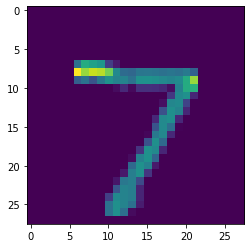

In [0]:
plt.imshow(x_test[0])
plt.show()

### **FASHION MNIST DATASET**

In [0]:
import tensorflow as tf
fashion = tf.keras.datasets.fashion_mnist

In [0]:
(fx_train, fy_train), (fx_test, fy_test) = fashion.load_data()

fx_train = tf.keras.utils.normalize(fx_train, axis=1)
fx_test = tf.keras.utils.normalize(fx_test, axis=1)

4423680/4422102 [==============================] - 0s 0us/step


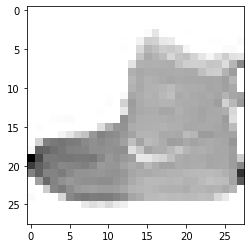

In [0]:
import matplotlib.pyplot as plt
plt.imshow(fx_train[0], cmap=plt.cm.binary)
plt.show()

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(700, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(fx_train,fy_train,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4567 - accuracy: 0.8303
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3451 - accuracy: 0.8713
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3084 - accuracy: 0.8843
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2825 - accuracy: 0.8931
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2642 - accuracy: 0.8985
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2464 - accuracy: 0.9056
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2316 - accuracy: 0.9111
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2195 - accuracy: 0.9150
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2095 - accuracy: 0.9201
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

In [0]:
val_loss, val_accuracy = model.evaluate(fx_test,fy_test)
print(val_loss, val_loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.3496 - accuracy: 0.8861
0.34958893060684204 0.34958893060684204


In [0]:
predictions = model.predict(fx_test)

In [0]:
import numpy as np
array = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(array[np.argmax(predictions[67])])

Dress


Dress


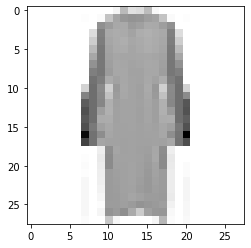

In [0]:
plt.imshow(fx_test[67], cmap=plt.cm.binary)
print(array[fy_test[67]])
plt.show()